In [7]:
import os
import sys
import tensorflow as tf
import cirq
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt

from encode_state import EncodeState
from leakage import LeakageModels
from input_circuits import InputCircuits
from loss import DiscriminationLoss
from noise.noise_model import TwoQubitNoiseModel, two_qubit_depolarize

In this notebook we will use the qutrit model and the normal model to compare preformance on the
state discrimination task.
So, this requires 4 qubits in the vanilla model, and 6 qubits in the leaky model.

In [2]:
n = 4
mu = 0.75
circuits = InputCircuits(n)
train_circuits, train_labels, test_circuits, test_labels = circuits.create_discrimination_circuits(mu_a=0.9)
encoder = EncodeState(n)
leakage = LeakageModels(2, 2, False, 0.3)
noise_model = TwoQubitNoiseModel(cirq.depolarize(0.01), two_qubit_depolarize(0.01))
noisy_sim = cirq.DensityMatrixSimulator(noise=noise_model)

discrimination_model = encoder.discrimination_model()
leakage_model = leakage.leaky_model()

loss = DiscriminationLoss(0.5, 0.5)
loss_fn = loss.discrimination_loss
discrimination_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                             loss = loss_fn)
leakage_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                             loss = loss_fn)

In [3]:
leakage_history = leakage_model.fit(
                        x=train_circuits,
                        y=train_labels,
                        batch_size=10,
                        epochs=7,
                        verbose=1,
                        validation_data=(test_circuits, test_labels))

Train on 700 samples, validate on 300 samples
Epoch 1/7
700/700 [==============================] - 18s 26ms/sample - loss: 0.3142 - val_loss: 0.2972

In [4]:
discrimination_history = discrimination_model.fit(x=train_circuits,
                        y=train_labels,
                        batch_size=10,
                        epochs=7,
                        verbose=1,
                        validation_data=(test_circuits, test_labels))

Train on 700 samples, validate on 300 samples
Epoch 1/7
700/700 [==============================] - 16s 24ms/sample - loss: 0.2444 - val_loss: 0.2234

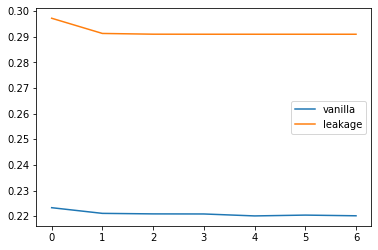

In [9]:
plt.plot(discrimination_history.history['val_loss'], label='vanilla')
plt.plot(leakage_history.history['val_loss'], label='leakage')
plt.legend()
plt.show()